# Multimoda RAG: 이미지 캡셔닝 기반 검색

Google Colab에서 진행하는 실습

In [1]:
!pip install langchain langchain-openai langchain-chroma pillow

INFO: pip is looking at multiple versions of langchain-openai to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of langchain-chroma to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 3.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.0/76.0 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.4/21.4 MB 87.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.2/278.2 kB 26.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 72.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.3/103.3 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.4/17.4 MB 92.1 MB/s eta 0:00:00
   ━

In [2]:
# 구글 드라이브 연동 (Google Colab에서만 사용 가능)
try:
    from google.colab import drive
    drive.mount('/content/drive')
    print("Google Drive is mounted.")
except ModuleNotFoundError:
    print("google.colab 모듈이 없어 Google Drive를 연동할 수 없습니다. 이 코드는 Colab 환경에서만 동작합니다.")

Mounted at /content/drive
Google Drive is mounted.


In [4]:
import os
from PIL import Image
import matplotlib.pyplot as plt

BASE_PATH = '/content/drive/MyDrive/Colab Notebooks/SKN19'

In [6]:
import os
from google.colab import userdata

os.environ['OPENAI_API_KEY'] = userdata.get('OPENAI_API_KEY')


### Indexing Phase: 이미지 캡셔닝 및 vectordb 저장

In [7]:
# 벡터 db 생성
from langchain_chroma.vectorstores import Chroma
from langchain_openai import OpenAIEmbeddings
from tqdm import tqdm # 진행 상황에 대해서 출력해주는 라이브러리

persistent_directory = f'{BASE_PATH}/chroma'
embeddings = OpenAIEmbeddings(model='text-embedding-3-small')
vectordb = Chroma(
    collection_name='multimodal_rag',
    embedding_function=embeddings,
    persist_directory=persistent_directory
)
vectordb

In [12]:
# 이미지 로드
figures_dir = os.path.join(BASE_PATH, 'figures')
fig_images = [
    os.path.join(figures_dir, f)
    for f in os.listdir(figures_dir)
    if f.lower().endswith('.jpg')
]
fig_images = sorted(fig_images)
fig_images

['/content/drive/MyDrive/Colab Notebooks/SKN19/figures/figure-1.jpg',
 '/content/drive/MyDrive/Colab Notebooks/SKN19/figures/figure-2.jpg',
 '/content/drive/MyDrive/Colab Notebooks/SKN19/figures/figure-3.jpg',
 '/content/drive/MyDrive/Colab Notebooks/SKN19/figures/figure-4.jpg',
 '/content/drive/MyDrive/Colab Notebooks/SKN19/figures/figure-5.jpg',
 '/content/drive/MyDrive/Colab Notebooks/SKN19/figures/figure-6.jpg',
 '/content/drive/MyDrive/Colab Notebooks/SKN19/figures/figure-7.jpg']

In [24]:
# 1. 이미지 base64 문자열로 변환(metadata)
# 2. 이미지별 캡셔닝(ocr, 설명)
import base64
from openai import OpenAI

client = OpenAI()
system_message = "아래 이미지를 안전교육 및 화재대비 관점에서 주제문구와 각 장면에 대해서 주요정보 손실없이 한국어로 요약해주세요."

def image_to_base64(image_path):
    with open(image_path, "rb") as f:
        return base64.b64encode(f.read()).decode('utf-8')

# image_to_base64('/content/drive/MyDrive/Colab Notebooks/SKN19/figures/figure-7.jpg')

def summarize_image(image_path):
    with open(image_path, 'rb') as f:
        response = client.chat.completions.create(
            model='gpt-4.1-mini-2025-04-14',
            messages=[
                {'role': 'system', 'content': system_message},
                {'role': 'user', 'content' : [
                    {'type': 'image_url',
                     'image_url': {'url': f'data:image/jpeg;base64,{image_to_base64(image_path)}'}}
                ]}
            ]
        )
    return response.choices[0].message.content


In [26]:
print(summarize_image('/content/drive/MyDrive/Colab Notebooks/SKN19/figures/figure-7.jpg'))

주제문구: 화재 예방 및 초기 대응을 위한 주요 설비

1. 제연설비: 화재 시 연기와 유해가스를 효과적으로 배출하여 인명 피해를 줄이고 화재 확산을 방지하는 장치입니다.
2. 화재감지기: 화재 발생 시 연기나 불꽃을 감지하여 경보를 울려 신속한 대피와 대응을 가능하게 합니다.
3. 스프링클러: 화재 발생 시 자동으로 작동하여 물을 분사, 화재를 초기 진압하는 설비입니다.
4. 주방용자동소화기: 주방 내 화재 발생 시 자동으로 작동하여 불을 신속하게 진압하는 장치입니다.


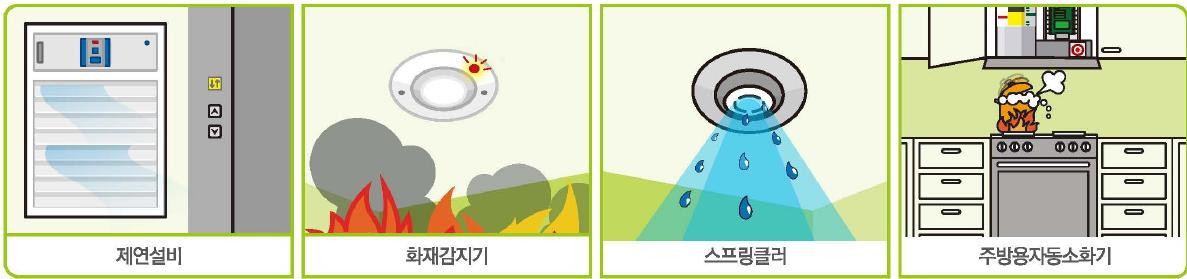

In [29]:
# figure-7.jpg 이미지 출력하기
image = Image.open('/content/drive/MyDrive/Colab Notebooks/SKN19/figures/figure-7.jpg')
display(image)

In [30]:
print(summarize_image('/content/drive/MyDrive/Colab Notebooks/SKN19/figures/figure-1.jpg'))

주제문구: 완강기 사용법 및 안전한 화재 대피 방법

1. 지지대 고리에 완강기 고리를 걸고 잡는다.  
2. 지지대를 창밖으로 밀고 릴(줄)을 던진다.  
3. 완강기 벨트를 가슴 높이까지 걸고 조인다.  
4. 벽을 짚으며 안전하게 아래로 내려간다.  

이 그림은 화재 시 완강기를 올바르게 사용하여 안전하게 대피하는 절차를 단계별로 보여주고 있습니다.


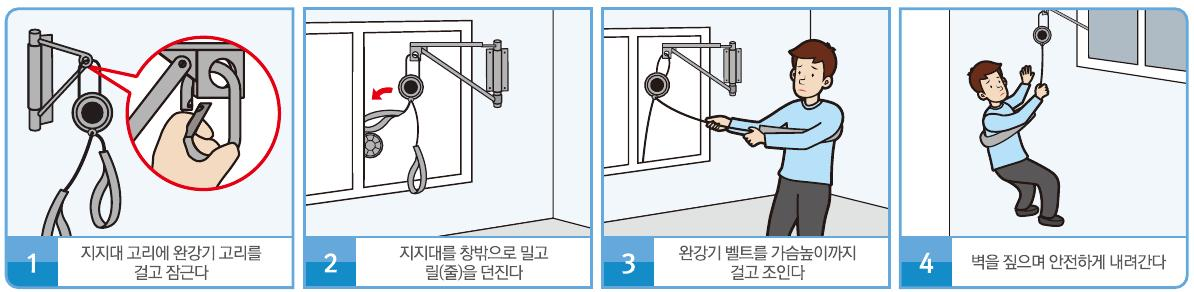

In [31]:
# figure-7.jpg 이미지 출력하기
image = Image.open('/content/drive/MyDrive/Colab Notebooks/SKN19/figures/figure-1.jpg')
display(image)

In [32]:
# 이미지캡셔닝/ vectordb 배치 저장
for fig_img_path in tqdm(fig_images):
    b64 = image_to_base64(fig_img_path)
    summary = summarize_image(fig_img_path)
    vectordb.add_texts(
        texts=[summary],
        metadatas=[{
            'base64_image': b64,
            'image_path': fig_img_path
            }]
    )

100%|██████████| 7/7 [00:33<00:00,  4.81s/it]


In [33]:
docs = vectordb._collection.get()
docs

{'ids': ['7eb00e0f-e1b1-457f-8a24-f884b4785afe',
  '66e90d30-e467-4938-826a-5b4f7f947b77',
  '8edfb4c9-19e6-4652-b896-f199fc5ef631',
  '75cc07cc-3812-425f-b12f-a6b467dbb956',
  '278b81ea-b109-46a0-82b5-4a337e7370d9',
  '5dcd1be8-aa32-4ea9-911e-b4e7007400b4',
  '44749a1a-a684-4fef-a988-9bf58deb52cd'],
 'embeddings': None,
 'documents': ['주제문구: 완강기 사용법 및 안전한 대피 방법\n\n1. 지지대 고리에 완강기 고리를 걸고 잡는다.\n2. 지지대를 창밖으로 밀고 릴(줄)을 던진다.\n3. 완강기 벨트를 가슴 높이까지 걸고 조인다.\n4. 벽을 짚으며 안전하게 내려간다.',
  '주제문구:  \n실내에서 사용할 때는 밖으로 대피할 때를 대비하여 문을 등지고 소화기를 안전하게 사용하는 방법\n\n요약:  \n1. 소화기를 가지고 몸통을 단단히 잡고 안전핀을 뺀다.  \n2. 노즐을 잡고 불쪽을 향해 가까이 이동한다.  \n3. 손잡이를 꽉 움켜쥔다.  \n4. 분말이 골고루 불을 덮을 수 있도록 분말을 골고루 쓴다.',
  '주제문구: 2인 1조 소화전 사용법 및 화재 진압 절차\n\n1. 문을 연다  \n- 2명 중 1명이 먼저 소화전함의 문을 열고, 호스와 노즐이 제대로 연결되어 있는지 확인한다.\n\n2. 호스를 빼고 노즐을 잡는다  \n- 호스를 밖으로 꼬이지 않게 길게 늘어뜨리고, 노즐(관창)을 잡아 방수 자세를 취한다.\n\n3. 밸브를 돌린다  \n- 다른 한 사람이 밸브를 돌려 물이 나오는지 확인한 후, 호스를 잡는 사람을 도와준다.\n\n4. 불을 향해 쏜다  \n- 호스를 잡은 사람이 불길을 향해 물을 정확히 분사하여 화재를 진압한다.\n\n요약: 2명이 한 조가 되어 소화전함 문

In [36]:
# 저장된 내용 가져오기
for idx, (doc, meta) in enumerate(zip(docs['documents'], docs['metadatas'])):
    print(f'[{idx + 1}]')
    print('summary', doc)
    print('metadata.image_path:', meta['image_path'])
    print('metadata.b64 len: ', len(meta['base64_image']))
    print(end='\n\n')

[1]
summary 주제문구: 완강기 사용법 및 안전한 대피 방법

1. 지지대 고리에 완강기 고리를 걸고 잡는다.
2. 지지대를 창밖으로 밀고 릴(줄)을 던진다.
3. 완강기 벨트를 가슴 높이까지 걸고 조인다.
4. 벽을 짚으며 안전하게 내려간다.
metadata.image_path: /content/drive/MyDrive/Colab Notebooks/SKN19/figures/figure-1.jpg
metadata.b64 len:  89544


[2]
summary 주제문구:  
실내에서 사용할 때는 밖으로 대피할 때를 대비하여 문을 등지고 소화기를 안전하게 사용하는 방법

요약:  
1. 소화기를 가지고 몸통을 단단히 잡고 안전핀을 뺀다.  
2. 노즐을 잡고 불쪽을 향해 가까이 이동한다.  
3. 손잡이를 꽉 움켜쥔다.  
4. 분말이 골고루 불을 덮을 수 있도록 분말을 골고루 쓴다.
metadata.image_path: /content/drive/MyDrive/Colab Notebooks/SKN19/figures/figure-2.jpg
metadata.b64 len:  116864


[3]
summary 주제문구: 2인 1조 소화전 사용법 및 화재 진압 절차

1. 문을 연다  
- 2명 중 1명이 먼저 소화전함의 문을 열고, 호스와 노즐이 제대로 연결되어 있는지 확인한다.

2. 호스를 빼고 노즐을 잡는다  
- 호스를 밖으로 꼬이지 않게 길게 늘어뜨리고, 노즐(관창)을 잡아 방수 자세를 취한다.

3. 밸브를 돌린다  
- 다른 한 사람이 밸브를 돌려 물이 나오는지 확인한 후, 호스를 잡는 사람을 도와준다.

4. 불을 향해 쏜다  
- 호스를 잡은 사람이 불길을 향해 물을 정확히 분사하여 화재를 진압한다.

요약: 2명이 한 조가 되어 소화전함 문을 열고, 호스와 노즐을 확인 후 한 명은 호스를 잡고, 다른 한 명이 밸브를 돌려 물을 틀어 불을 진압하는 안전절차를 설명한다.
metadata.image_path: /content/drive/M

### Retrieval/Generation Phase:

##### Retrieval

전체 흐름 과정 이해

1. 이미지 -> 이미지 캡셔닝
2. (1) page_content : 백터화 하는 주요 내용 = 이미지 캡셔닝
   (2) metadata : 이미지를 base64 이진 데이터로 변환한 것을 저장했다.
3. 사용자는 query를 전달 : 즉, 텍스트로 질의를 제공
4. 벡터db 안에 저장되어있는 것들을 유사도 검색
5. query와 이미지 캡셔닝한 텍스트와 유사도 검색 출력
6. 내용 출력-> 이미지 캡셔닝 -> 이미지 출력 -> 메타데이터


[TOP-1] 요약: 주제문구: 2인 1조 소화전 사용법 및 화재 진압 절차

1. 문을 연다  
- 2명 중 1명이 먼저 소화전함의 문을 열고, 호스와 노즐이 제대로 연결되어 있는지 확인한다.

2. 호스를 빼고 노즐을 잡는다  
- 호스를 밖으로 꼬이지 않게 길게 늘어뜨리고, 노즐(관창)을 잡아 방수 자세를 취한다.

3. 밸브를 돌린다  
- 다른 한 사람이 밸브를 돌려 물이 나오는지 확인한 후, 호스를 잡는 사람을 도와준다.

4. 불을 향해 쏜다  
- 호스를 잡은 사람이 불길을 향해 물을 정확히 분사하여 화재를 진압한다.

요약: 2명이 한 조가 되어 소화전함 문을 열고, 호스와 노즐을 확인 후 한 명은 호스를 잡고, 다른 한 명이 밸브를 돌려 물을 틀어 불을 진압하는 안전절차를 설명한다.


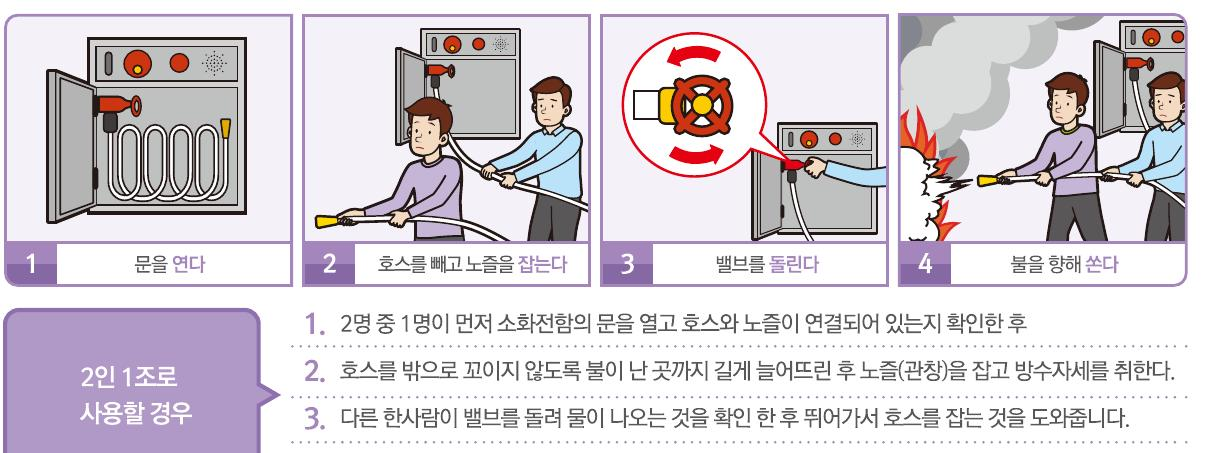


[TOP-2] 요약: 주제문구:  
화재 시 안전하게 대피하는 방법

각 장면 요약:  
1. 손수건이나 옷 등을 이용해 코와 입을 막아 호흡기를 보호한다.  
2. 연기층 아래로 자세를 낮추어 연기를 피한다.  
3. 다른 손으로 벽을 짚으며 안전하게 이동한다.  
4. 한쪽 방향으로 신속히 이동하여 밖으로 대피한다.


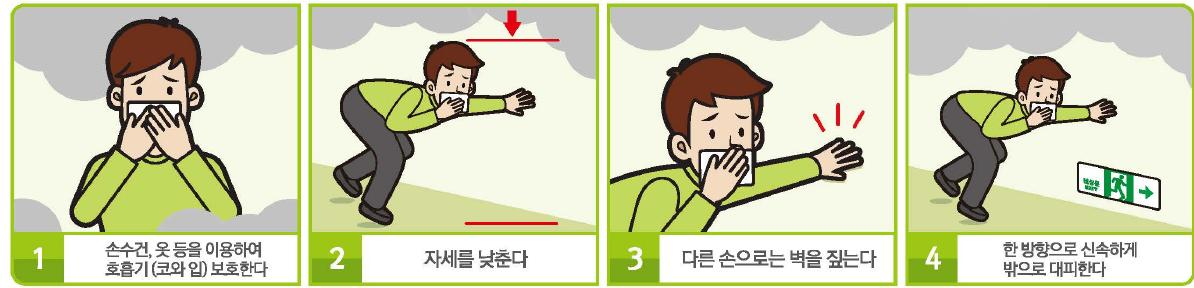

In [38]:
from PIL import Image
from io import BytesIO

def show_base64_image(b64_str):
    img = Image.open(BytesIO(base64.b64decode(b64_str)))
    display(img)


def search_and_show(query, k=2):
    docs = vectordb.similarity_search(query, k=k)
    # print(docs)
    for i, doc in enumerate(docs):
        print(f'\n[TOP-{i + 1}] 요약: {doc.page_content}')
        show_base64_image(doc.metadata['base64_image'])


query = '화재시 피난 요령에 대해서 알려줘.'
# 1. query embedding 변환 후 vectordb의 문서와 유사도 검색
# 2. 내용 출력, 이미지 출력
search_and_show(query)

##### RetrievalQA (retrieval + generation)

In [40]:
from langchain.chains import RetrievalQA
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(
    model='gpt-4o',
    temperature=0
)

retriever = vectordb.as_retriever(search_kwargs={'k':2})
qa_chain = RetrievalQA.from_chain_type(
    llm=llm,
    retriever=retriever,
    chain_type='stuff', # 문서의 내용을 연결해 llm 전달
    return_source_documents=True
)

query = '화재시 대피요령'
result = qa_chain.invoke(query)
print(result)
print(result['result'])

{'query': '화재시 대피요령', 'result': '화재 시 대피 요령은 다음과 같습니다:\n\n1. 손수건이나 옷 등을 이용해 코와 입을 막아 호흡기를 보호합니다.\n2. 연기층 아래로 자세를 낮추어 연기를 피합니다.\n3. 다른 손으로 벽을 짚으며 안전하게 이동합니다.\n4. 한쪽 방향으로 신속히 이동하여 밖으로 대피합니다.', 'source_documents': [Document(id='278b81ea-b109-46a0-82b5-4a337e7370d9', metadata={'image_path': '/content/drive/MyDrive/Colab Notebooks/SKN19/figures/figure-5.jpg', 'base64_image': '/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCAEgBKoDASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFE

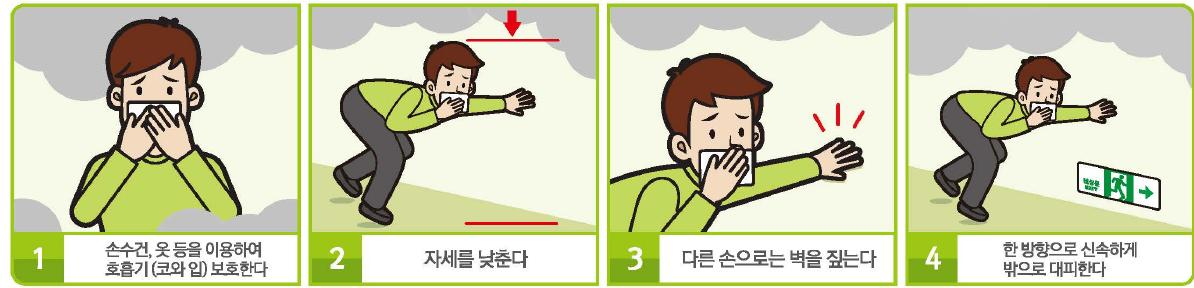

주제문구:  
화재 시 안전하게 대피하는 방법

각 장면 요약:  
1. 손수건이나 옷 등을 이용해 코와 입을 막아 호흡기를 보호한다.  
2. 연기층 아래로 자세를 낮추어 연기를 피한다.  
3. 다른 손으로 벽을 짚으며 안전하게 이동한다.  
4. 한쪽 방향으로 신속히 이동하여 밖으로 대피한다.


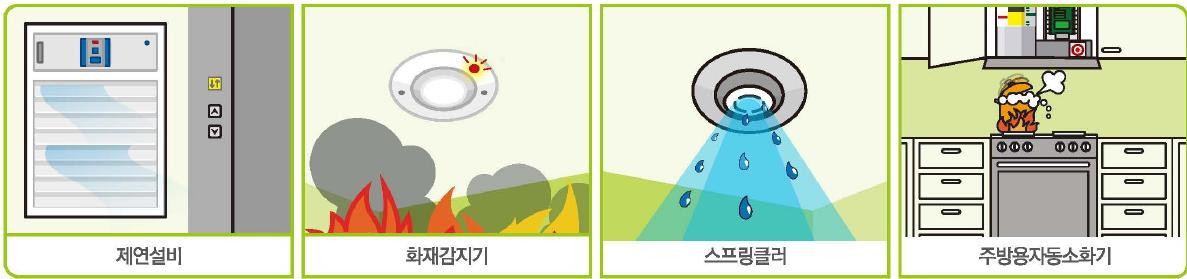

주제문구: 화재 예방 및 초기 대응을 위한 안전설비 이해

1. 제연설비: 화재 시 연기를 차단하고 배출하여 대피로 확보 및 화재 확산 방지 역할을 하는 설비
2. 화재감지기: 화재 발생 시 연기나 열을 감지하여 경보를 울려 신속한 대응을 돕는 장치
3. 스프링클러: 화재 발생 시 자동으로 물을 분사하여 불길을 초기 진압하는 소화장치
4. 주방용자동소화기: 주방 화재 시 자동으로 작동하여 화재를 신속히 진압하는 소화시스템


In [41]:
for doc in result['source_documents']:
    show_base64_image(doc.metadata['base64_image'])
    print(doc.page_content)

In [ ]:
docs =